Nombre: Diego Armando Parraga Ortuste


link imagenes: https://drive.google.com/file/d/1Fq0qztgkp5gvFKRTJ5bnXHY9a80FKYce/view?usp=drive_link

# *Multi-head Attention*

En el post anterior implementamos el mecanismo de atención básico del *Transforemer*. Sin embargo, vimos que la capacidad de representación de este mecanismo era limitada. Para resolver este problema, los autores de [*Attention is all you need*](https://arxiv.org/abs/1706.03762) proponen una mejora conocida como *Multi-head attention*.

![](https://github.com/juansensio/blog/blob/master/062_multihead_attention/multiheadattention.png?raw=1)

Este mecanismo toma inspiración en el uso de múltiples filtros en una red convolucional para mejorar la capacidad de representación de datos. En el contexto de atención, esto se traduce en repetir un número determinado de veces (*heads* o cabezas) el mecanismo de *scaled-dot product attention* que conocemos del post anterior.

$$MultiHead(Q,K,V)= Concat(head_1, ..., head_h) W^o$$

donde

$$ head_i = Attention(QW_q^i, KW_k^i, VW_v^i) $$

A grandes rasgos, repetimos el mecanismo de atención aplicando diferentes proyecciones a la hora de obtener nuestras *queries*, *keys* y *values*. Una vez aplicada la atención a cada cabeza, concatenamos los resultados y aplicamos una nueva capa lineal para obtener el resultado final.

Vamos a ver esta implementación en el mismo ejemplo anterior.

In [1]:
!pip install pytorch-lightning

## Implementación

In [2]:
import pytorch_lightning as pl
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.datasets import fetch_openml
import numpy as np
from torch.utils.data import DataLoader
from scipy.io import loadmat

from torchvision import datasets, transforms

import pandas as pd
#from tensorflow import keras

In [3]:
import os
import random
import numpy as np
from PIL import Image

def cargar_dataset_train(ruta_dataset, tamaño_imagen=(50, 50)):
    # Reiniciar variables
    dataset = []
    etiquetas_mapping = {}

    # Obtener clases del nuevo dataset y ordenarlas
    clases = sorted(os.listdir(ruta_dataset))

    # Mapeo de etiquetas a valores numéricos
    etiquetas_mapping = {clase: idx for idx, clase in enumerate(clases)}

    for clase in clases:
        #print(f"Procesando clase testing: {clase} ({etiquetas_mapping[clase]})")
        ruta_clase = os.path.join(ruta_dataset, clase)
        etiqueta_num = etiquetas_mapping[clase]  # Obtener el valor numérico de la etiqueta directamente
        with os.scandir(ruta_clase) as entries:
            for idx, entry in enumerate(entries, start=1):
                if entry.is_file():
                    imagen_ruta = os.path.join(ruta_clase, entry.name)
                    # Abrir imagen como objeto PIL
                    imagen = Image.open(imagen_ruta).convert('RGB')
                    # No se realiza la normalización
                    # Convertir la imagen a objeto PIL
                    imagen_pil = Image.fromarray(np.array(imagen))
                    # Redimensionar imagen
                    imagen_resized = imagen_pil.resize(tamaño_imagen)
                    dataset.append((imagen_resized, etiqueta_num))  # Tupla con imagen y etiqueta numérica

    random.shuffle(dataset)
    return dataset

In [4]:
Perrossets = cargar_dataset_train('completados')
print("Número de ejemplos en el conjunto de entrenamiento:", len(Perrossets))

Número de ejemplos en el conjunto de entrenamiento: 60484


In [5]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    return torch.tensor(self.X[ix]).float(), torch.tensor(self.y[ix]).long()

class DataModule(pl.LightningDataModule):

    def __init__(self, batch_size: int = 64, Dataset = Dataset):
        super().__init__()
        self.batch_size = batch_size
        self.Dataset = Dataset

    def setup(self, stage=None):
        images = np.array([np.array(img) for img, label in Perrossets])
        labels = np.array([label for img, label in Perrossets])
        X_train, X_test = images[:50000], images[10000:]
        y_train, y_test = labels[:50000], labels[10000:]
        X_train = X_train.reshape(-1, 7500)
        X_test = X_test.reshape(-1, 7500)
        X_train, y_train = X_train /255, y_train.astype(np.int64)
        X_test, y_test = X_test /255, y_test.astype(np.int64)
        self.train_ds = self.Dataset(X_train, y_train)
        self.val_ds = self.Dataset(X_test, y_test)

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_ds, batch_size=self.batch_size)

In [6]:
dm = DataModule()
dm.setup()
imgs, labels = next(iter(dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 7500]), torch.Size([64]))

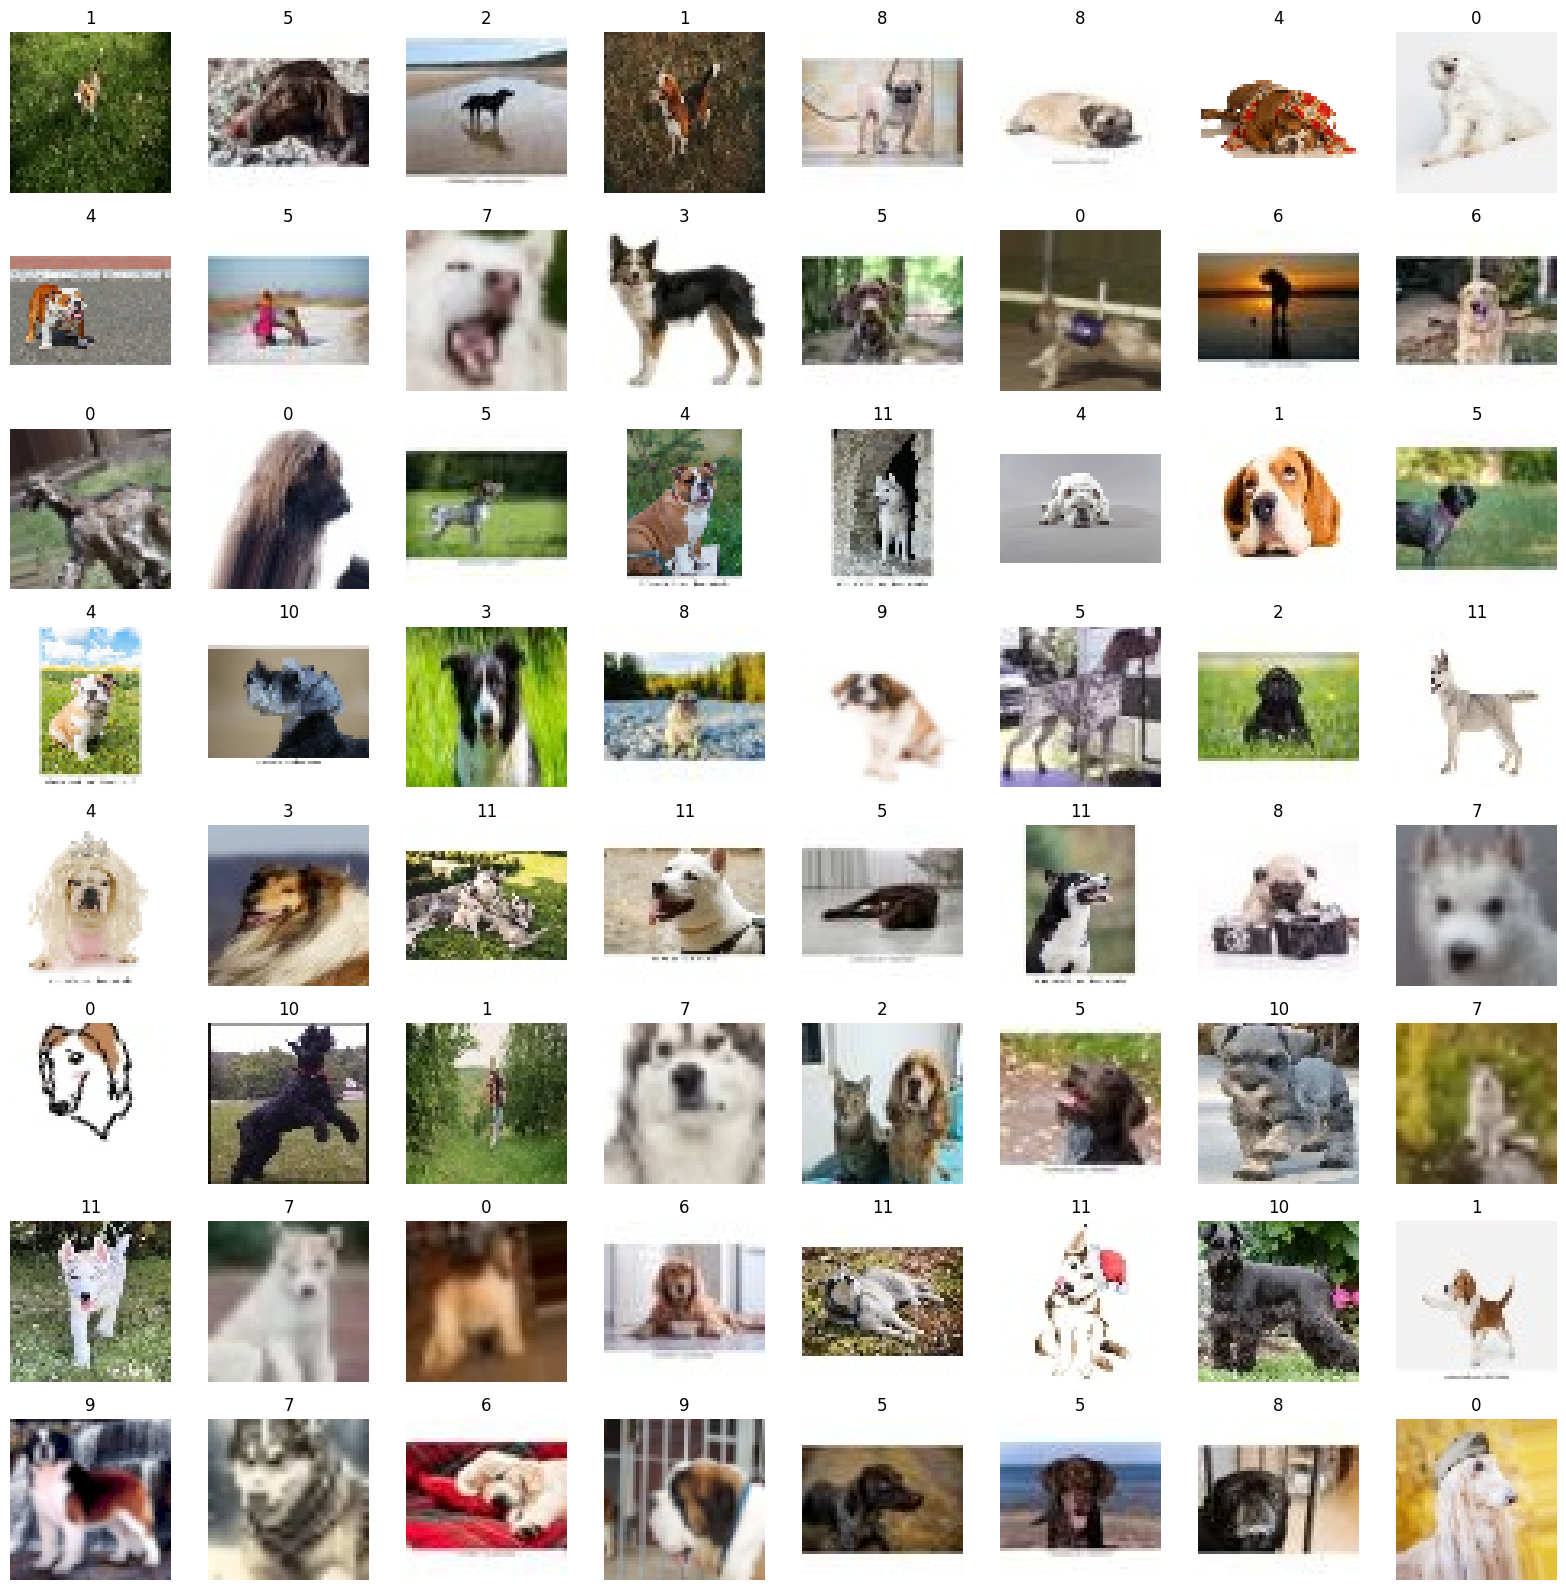

In [7]:
r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(50,50,3))
        ax.set_title(label.item())
plt.tight_layout()
plt.show()

In [8]:
class MLP(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(7500, 7500),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(7500, 12)
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [9]:
mlp = MLP()
outuput = mlp(torch.randn(64, 7500))
outuput.shape

torch.Size([64, 12])

In [10]:
mlp = MLP()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlp, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3050') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 56.3 M
------------------------------------
56.3 M    Trainable params
0         Non-trainable params
56.3 M    Total params
225.390   Total estimated model params size (MB)


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 24.43it/s, v_num=2, acc=0.188, val_loss=2.050, val_acc=0.275] 

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [00:34<00:00, 22.70it/s, v_num=2, acc=0.188, val_loss=2.050, val_acc=0.275]


Obtenemos una precisión en los datos de validación del 97%, nada impresionante debido a la simplicidad del modelo.

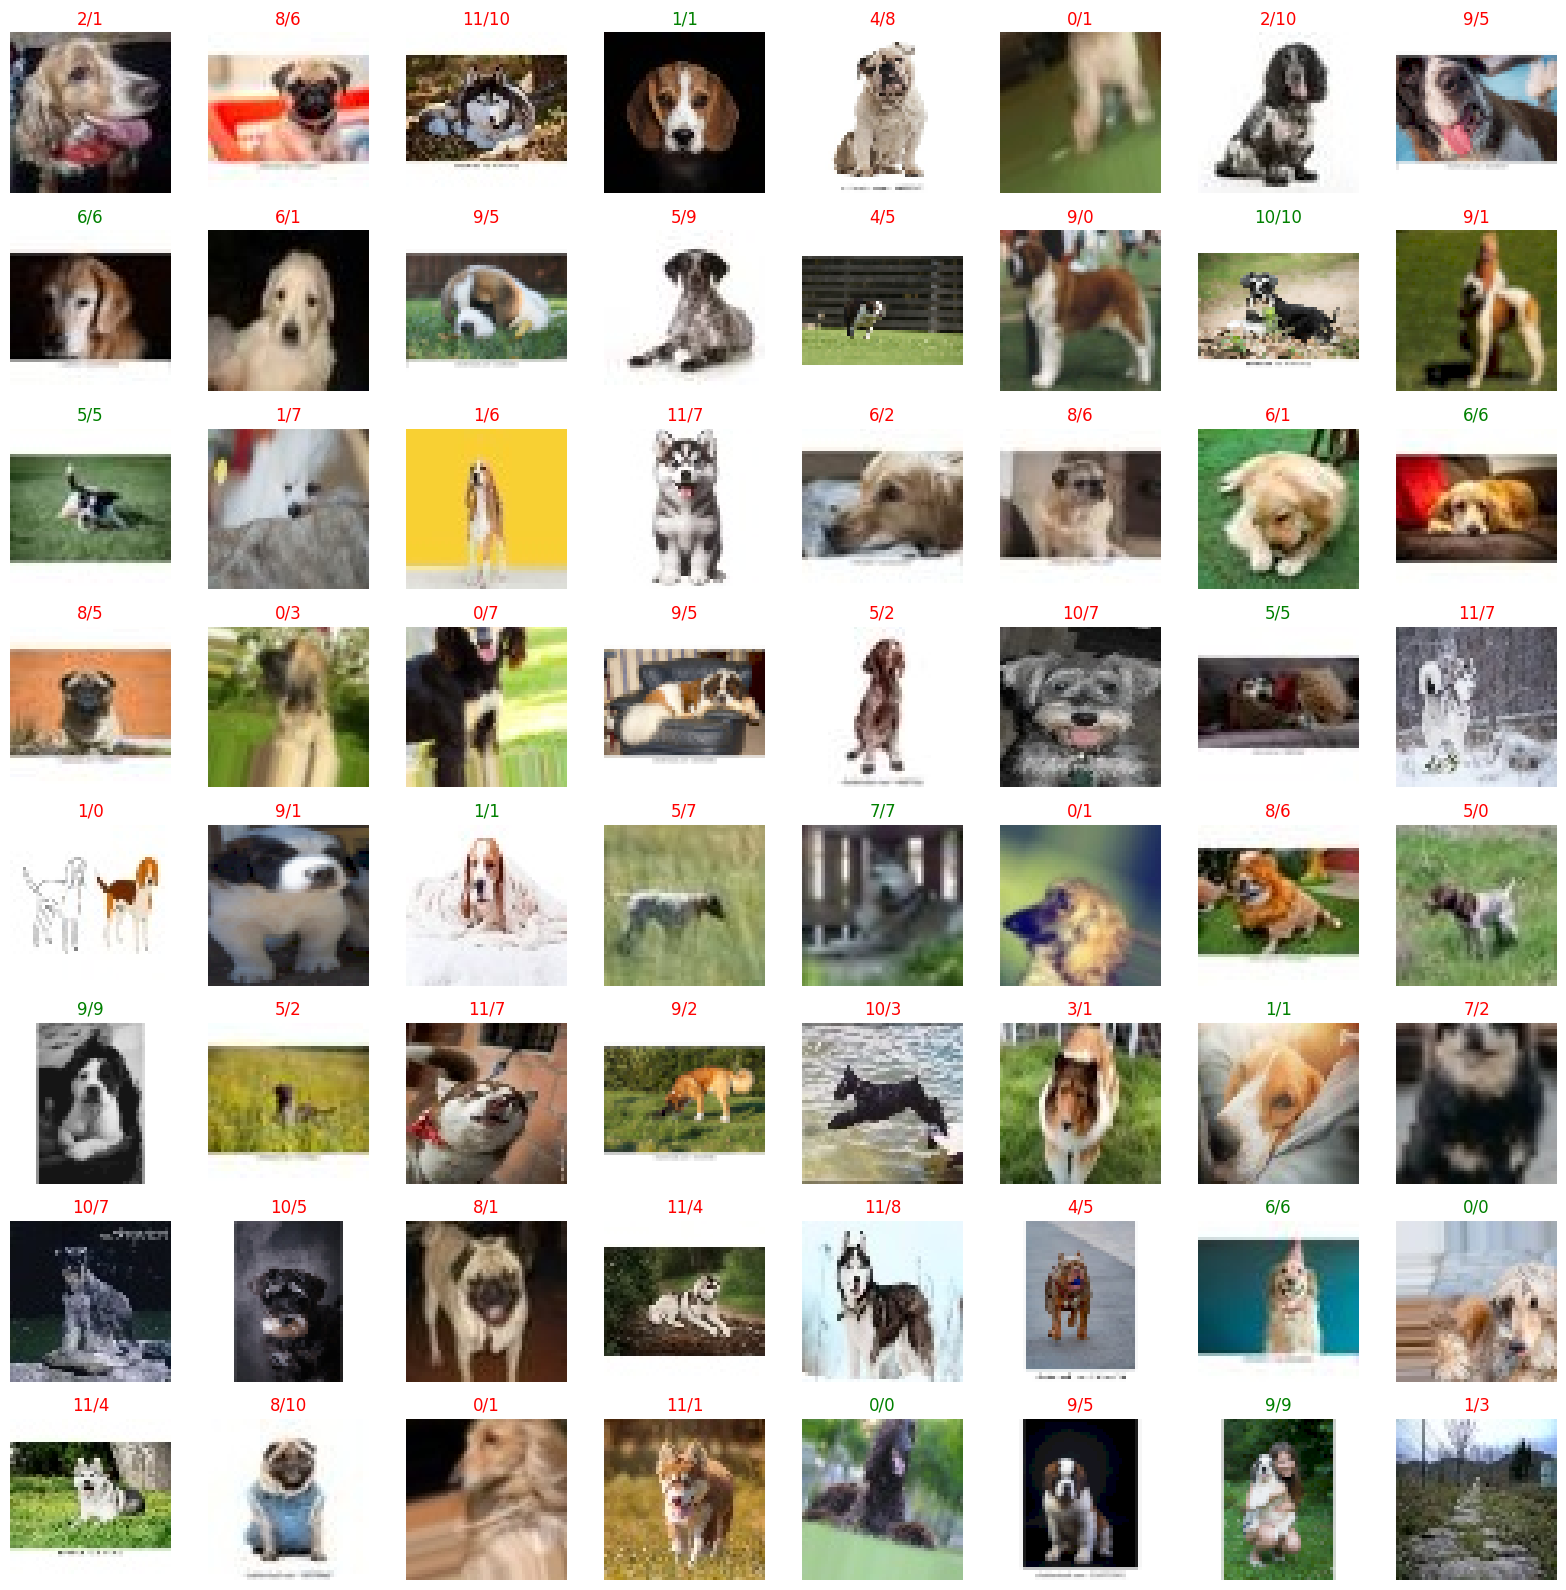

In [11]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlp.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(50,50,3), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

In [92]:
class MLPNorm(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(7500, 7500),
            torch.nn.BatchNorm1d(7500),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(7500, 12),
        )

    def forward(self, x):
        return self.mlp(x)

    def predict(self, x):
        with torch.no_grad():
          y_hat = self(x)
          return torch.argmax(y_hat, axis=1)

    def compute_loss_and_acc(self, batch):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = (torch.argmax(y_hat, axis=1) == y).sum().item() / y.shape[0]
        return loss, acc

    def training_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('loss', loss)
        self.log('acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.compute_loss_and_acc(batch)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.003)
        return optimizer

In [93]:
mlpN = MLPNorm()
outuput = mlpN(torch.randn(64, 7500))
outuput.shape

torch.Size([64, 12])

In [95]:
mlpN = MLPNorm()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(mlpN, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | mlp  | Sequential | 56.4 M
------------------------------------
56.4 M    Trainable params
0         Non-trainable params
56.4 M    Total params
225.450   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


c:\Users\Diego-pc\AppData\Local\Programs\Python\Python312\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 4: 100%|██████████| 782/782 [00:32<00:00, 24.02it/s, v_num=10, acc=0.375, val_loss=1.760, val_acc=0.435]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [00:35<00:00, 22.32it/s, v_num=10, acc=0.375, val_loss=1.760, val_acc=0.435]


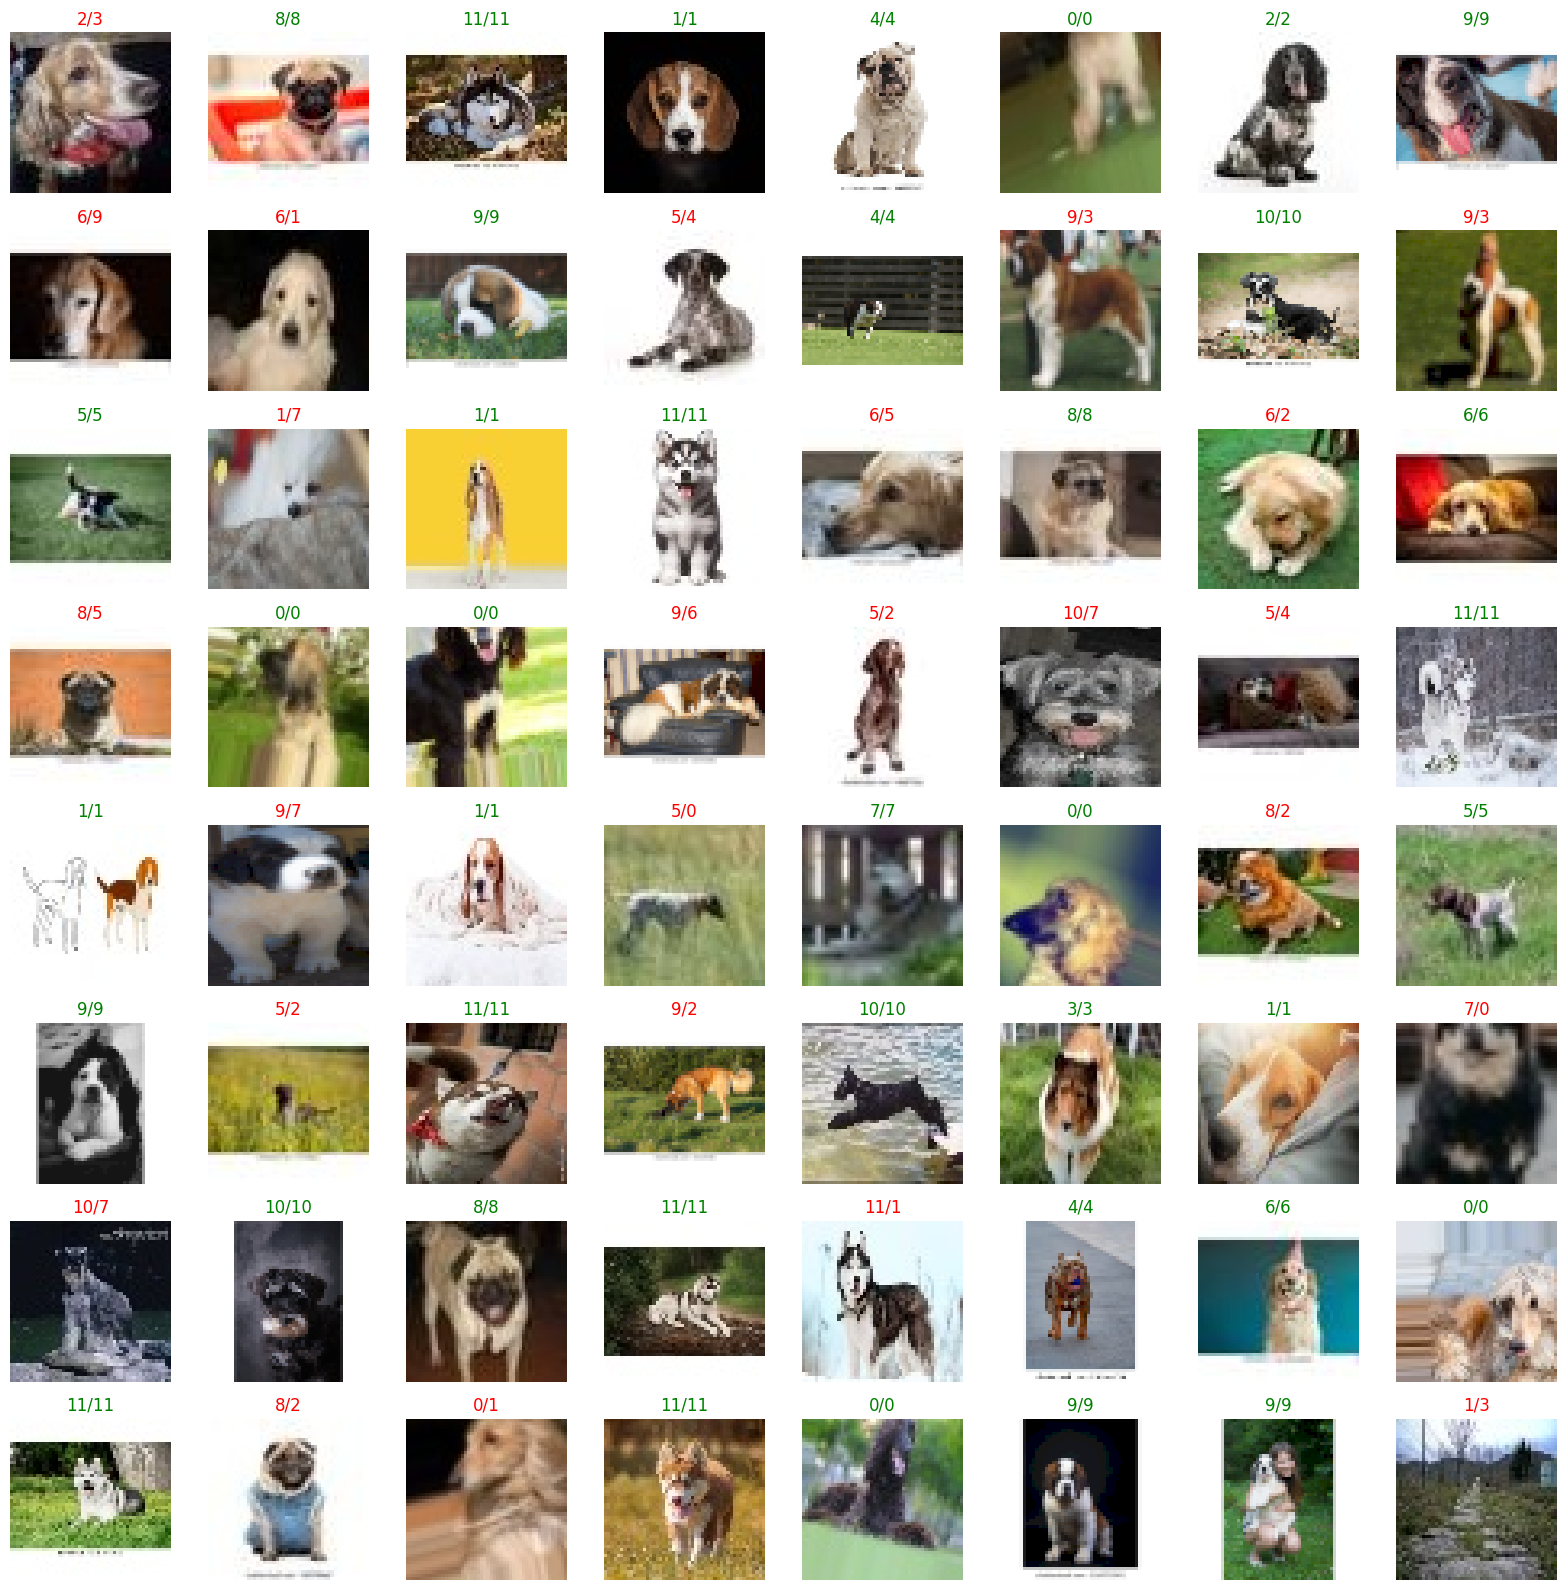

In [96]:
imgs, labels = next(iter(dm.val_dataloader()))
preds = mlpN.predict(imgs)

r, c = 8, 8
fig = plt.figure(figsize=(2*c, 2*r))
for _r in range(r):
    for _c in range(c):
        ix = _r*c + _c
        ax = plt.subplot(r, c, ix + 1)
        img, label = imgs[ix], labels[ix]
        ax.axis("off")
        ax.imshow(img.reshape(50,50,3), cmap="gray")
        ax.set_title(f'{label.item()}/{preds[ix].item()}', color="green" if label == preds[ix] else 'red')
plt.tight_layout()
plt.show()

Vamos ahora a resolver el mismo problema, utilizando el mecanismo de atención descrito anteriormente. Lo primero que tenemos que tener en cuenta es que los mecanismos de atención funcionan con secuencias, por lo que tenemos que reinterpretar nuestras imágenes. Para ello, vamos a dividirlas en 16 *patches* de 7x7. De esta manera, nuestras imágenes ahora serán secuencias de *patches* con las que nuestro mecanismo de atención podrá trabajar.

In [72]:
class AttnDataset(torch.utils.data.Dataset):
  def __init__(self, X, y, patch_size=(10, 10)):
    self.X = X
    self.y = y
    self.patch_size = patch_size

  def __len__(self):
    return len(self.X)

  def __getitem__(self, ix):
    image = torch.tensor(self.X[ix]).float().view(50, 50, 3) # 50 x 50 x 3
    h, w = self.patch_size
    patches = image.unfold(0, h, h).unfold(1, w, w).unfold(2,3,3) # 5 x 5 x 10 x 10 x 3
    patches = patches.contiguous().view(-1, h*w*3) # 25 x 300
    return patches, torch.tensor(self.y[ix]).long()

In [73]:
attn_dm = DataModule(Dataset = AttnDataset)
attn_dm.setup()
imgs, labels = next(iter(attn_dm.train_dataloader()))
imgs.shape, labels.shape

(torch.Size([64, 25, 300]), torch.Size([64]))

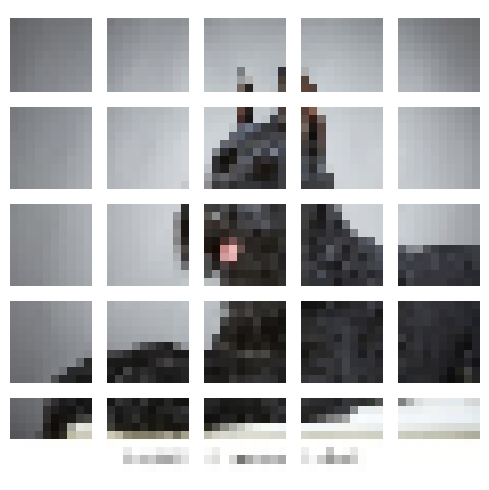

In [75]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(5,5))
for i in range(5):
    for j in range(5):
        ax = plt.subplot(5, 5, (i*5) + j + 1)
        ax.imshow(imgs[6,i*5 + j].view(10, 10, 3))
        ax.axis('off')
plt.tight_layout()
plt.show()

Debido a la baja dimensionalidad de nuestro ejemplo, vamos a repetir nuestro mecanismo de atención básico `n_heads` número de veces. Sin embargo, en la práctica, se divide la dimensión del `embedding` por este número de cabezas. Un detalle importante a tener en cuenta :)

In [89]:
# basado en: https://github.com/karpathy/minGPT/blob/master/mingpt/model.py
import math

class MultiHeadAttention(torch.nn.Module):

    def __init__(self, n_embd, n_heads):
        super().__init__()
        self.n_heads = n_heads

        # key, query, value projections
        self.key = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.query = torch.nn.Linear(n_embd, n_embd*n_heads)
        self.value = torch.nn.Linear(n_embd, n_embd*n_heads)

        # output projection
        self.proj = torch.nn.Linear(n_embd*n_heads, n_embd)

    def forward(self, x):
        B, L, F = x.size()

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        k = self.key(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        q = self.query(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)
        v = self.value(x).view(B, L, F, self.n_heads).transpose(1, 3) # (B, nh, L, F)

        # attention (B, nh, L, F) x (B, nh, F, L) -> (B, nh, L, L)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = torch.nn.functional.softmax(att, dim=-1)
        y = att @ v # (B, nh, L, L) x (B, nh, L, F) -> (B, nh, L, F)
        y = y.transpose(1, 2).contiguous().view(B, L, F*self.n_heads) # re-assemble all head outputs side by side

        return self.proj(y)

class Model(MLP):

    def __init__(self, n_embd=10*10*3, seq_len=5*5, n_heads=5*5):
        super().__init__()
        self.mlp = None

        self.attn = MultiHeadAttention(n_embd, n_heads)
        self.bn = torch.nn.BatchNorm1d(n_embd*seq_len)
        self.actn = torch.nn.ReLU(inplace=True)
        self.fc = torch.nn.Linear(n_embd*seq_len, 12)

    def forward(self, x):
        x = self.attn(x)
        x = x.view(x.size(0), -1)
        x = self.bn(x)
        x = x.view(x.size(0), -1, 1, 1)
        #print(x.shape)
        y = self.fc(self.actn(x.view(x.size(0), -1)))
        #print(y.shape)
        return y

In [90]:
model = Model()
trainer = pl.Trainer(max_epochs=5, logger=None)
trainer.fit(model, attn_dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type               | Params
--------------------------------------------
0 | attn | MultiHeadAttention | 9.0 M 
1 | bn   | BatchNorm1d        | 15.0 K
2 | actn | ReLU               | 0     
3 | fc   | Linear             | 90.0 K
--------------------------------------------
9.1 M     Trainable params
0         Non-trainable params
9.1 M     Total params
36.511    Total estimated model params size (MB)


Epoch 4: 100%|██████████| 782/782 [01:58<00:00,  6.58it/s, v_num=9, acc=0.562, val_loss=1.720, val_acc=0.453]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 782/782 [01:59<00:00,  6.54it/s, v_num=9, acc=0.562, val_loss=1.720, val_acc=0.453]


Ahora nuestro modelo tiene mayor capacidad de representación (más parámetros) y, por lo tanto, obtenemos resultados mejores.

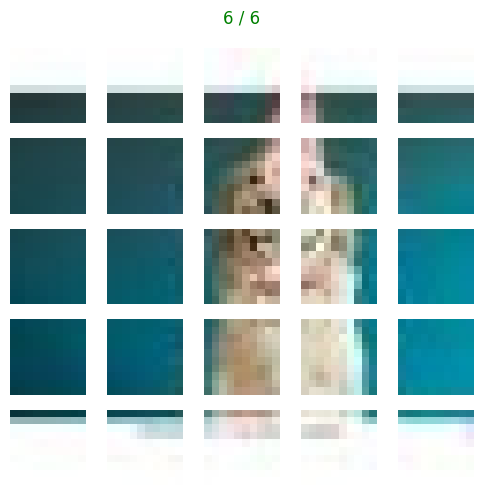

In [91]:
import random

attn_imgs, attn_labels = next(iter(attn_dm.val_dataloader()))
preds = model.predict(attn_imgs)

ix = random.randint(0,attn_dm.batch_size)
fig = plt.figure(figsize=(5,5))
for i in range(5):
    for j in range(5):
        ax = plt.subplot(5, 5, i*5 + j + 1)
        ax.imshow(attn_imgs[ix,i*5 + j].view(10, 10,3))
        ax.axis('off')
fig.suptitle(f'{attn_labels[ix]} / {preds[ix].item()}', color="green" if attn_labels[ix] == preds[ix].item() else "red")
plt.tight_layout()
plt.show()

## Resumen

Hemos visto como mejorar el mecanismo de atención añadiendo varias "cabezas" a las cuales atender en paralelo. De esta forma, la capacidad para representar datos de nuestro modelo se ve incrementada. Si bien el mecanismo de *multi-head self attention* es la base del *Transformer*, la capa básica del mismo requiere de un par de detalles extras para funcionar que veremos en el siguiente post.
Ademas que ayuda mucho la normalizacion para mejorara la estabilidad de los valores ya que al usar dicho data set se generaran saltos grandes entre los valores de acc y esto mantiene una estabilidad ayudando al entrenamiento